### Importing Libraries for Computer Vision and GradCAM Evaluation

In [25]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC

from tensorflow.keras.applications import ResNet50V2, ResNet50, InceptionV3, Xception

from pytorch_grad_cam.grad_cam import GradCAM
from pytorch_grad_cam.score_cam import ScoreCAM
from pytorch_grad_cam.grad_cam_plusplus import GradCAMPlusPlus

from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

### Loading Dataset


*LINK to Kaggle dataset below*

[![Kaggle Dataset](https://img.shields.io/badge/Kaggle-Microorganism_Image_Classification-blue.svg?logo=kaggle&style=for-the-badge)](https://www.kaggle.com/datasets/mdwaquarazam/microorganism-image-classification/data)

In [2]:
path = kagglehub.dataset_download("mdwaquarazam/microorganism-image-classification")
print(f"Path to dataset files: {path}")

subfolder_name = os.listdir(path)[0] 
data_dir = os.path.join(path, subfolder_name)

classes_names = sorted(os.listdir(data_dir))
n_classes = len(classes_names)

class_distribution = {name: len(os.listdir(os.path.join(data_dir, name))) for name in classes_names}

print(f"Number of classes: {n_classes} \nClass Names: {classes_names}")

Path to dataset files: C:\Users\chris\.cache\kagglehub\datasets\mdwaquarazam\microorganism-image-classification\versions\6
Number of classes: 8 
Class Names: ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']


### Exploratory Data Analysis

In [3]:
total_images = sum(class_distribution.values())


text_labels = [f'{(value / total_images) * 100:.2f}%' for value in class_distribution.values()]

fig = px.bar(
    x=classes_names, 
    # Make Y a %
    y=[(value / total_images) * 100 for value in class_distribution.values()], 
    text=text_labels, 
    title="Microorganism Class Distribution"
)

fig.update_traces(textposition='outside')

fig.update_layout({'title': {'x':0.5}})

fig.show()

### EDA Interpretation
- It appears the number of obervations for each lass is unevenly distirbuted in the dataset. 
- some classes appear to have more data(Euglena & Paramecium) while some have less(Hydra and Amoeba) 

### Data Pre-Processing

In [4]:
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    validation_split=0.1
)

### Defining Training & Validation Sets

In [5]:
train_df = gen.flow_from_directory(
    data_dir,
    batch_size=128,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256),
    subset='training'
)

val_df = gen.flow_from_directory(
    data_dir,
    batch_size=64,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256),
    subset='validation'
)





Found 714 images belonging to 8 classes.
Found 75 images belonging to 8 classes.


### Function to Visulaize Images

In [6]:
def visualize_images(data, GRID=[2,6], model=None, size=(25,10)):

    n_row, n_col = GRID
    n_images = n_row * n_col
    plt.figure(figsize = size)

    images,labels = next(iter(data))

    for i in range(1, n_images + 1):

        id = np.random.randint(len(images))

        image, label = images[id], classes_names[int(labels[id])]

        plt.subplot(n_row,n_col, i)
        plt.imshow(image)
        plt.axis('off')


        if model is not None:
            pred = classes_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class: {label}\nPred: {pred}"

        else:
            title = f"Class: {label}"

        plt.title(title)
    plt.show()

        

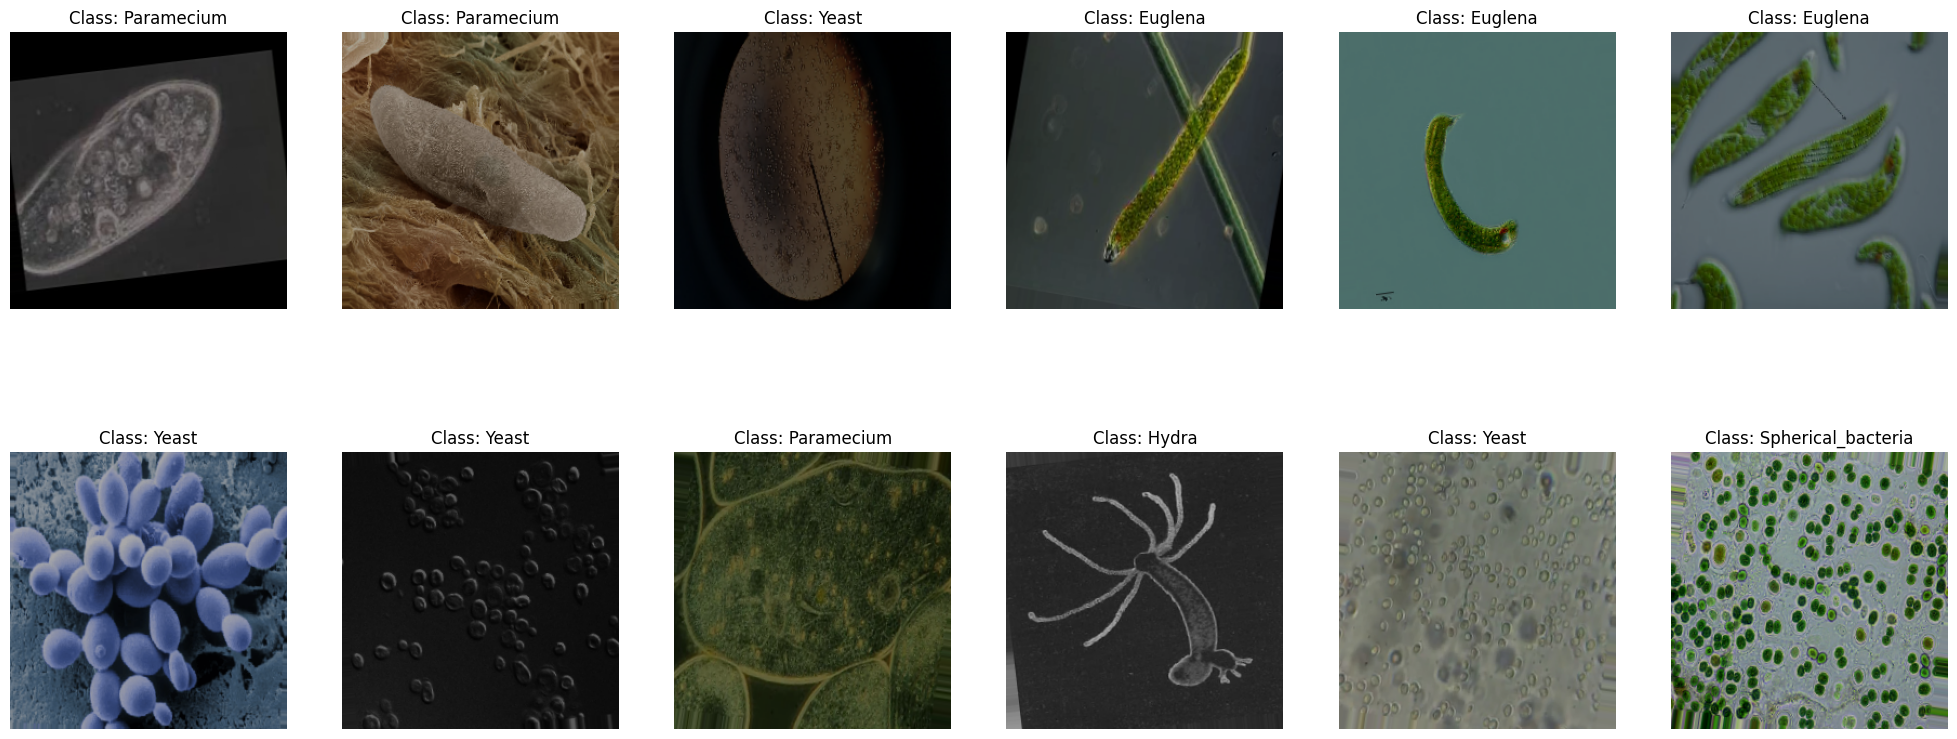

In [7]:
visualize_images(data=train_df, model=None)

# Implementing Inception-v3-Model (NO GradCAM Yet)

In [8]:
name = "inception-v3"

base = InceptionV3(input_shape=(256,256,3), include_top=False)
base.trainable = False

model = Sequential([
    base,
    GAP(),
    Dense(256, kernel_initializer='he_normal', activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

callbacks = [ES(patience=3, restore_best_weights=True), MC(name + '.h5', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss ='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(train_df, validation_data=val_df, epochs=50, callbacks=callbacks)

c:\Users\chris\miniforge3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1795 - loss: 2.4689

6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.2171 - loss: 2.4516 - val_accuracy: 0.4533 - val_loss: 1.8256
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4194 - loss: 1.7047

6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.4454 - loss: 1.6114 - val_accuracy: 0.4400 - val_loss: 1.4579
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5623 - loss: 1.3041

6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.5854 - loss: 1.2566 - val_accuracy: 0.5600 - val_loss: 1.3014
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6436 - loss: 1.0915

6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.6415 - loss: 1.0807 - val_accuracy: 0.6000 - val_loss: 1.1170
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6911 - loss: 0.9233

6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.6821 - loss: 0.9420 - val_accuracy: 0.6533 - val_loss: 1.0820
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7309 - loss: 0.8214

6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.7199 - loss: 0.8462 - val_accuracy: 0.7067 - val_loss: 0.9443
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.7675 - loss: 0.7472 - val_accuracy: 0.7067 - val_loss: 1.0078
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.7871 - loss: 0.6756 - val_accuracy: 0.6933 - val_loss: 0.9795
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8177 - loss: 0.6032

6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.8067 - loss: 0.6122 - val_accuracy: 0.6933 - val_loss: 0.8987
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.8207 - loss: 0.5699 - val_accuracy: 0.6800 - val_loss: 1.0421
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.8375 - loss: 0.5025 - val_accuracy: 0.6800 - val_loss: 0.9738
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.8754 - loss: 0.4682 - val_accuracy: 0.7067 - val_loss: 1.0167


### Initial Prediciton vs Actual Class Comparison

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


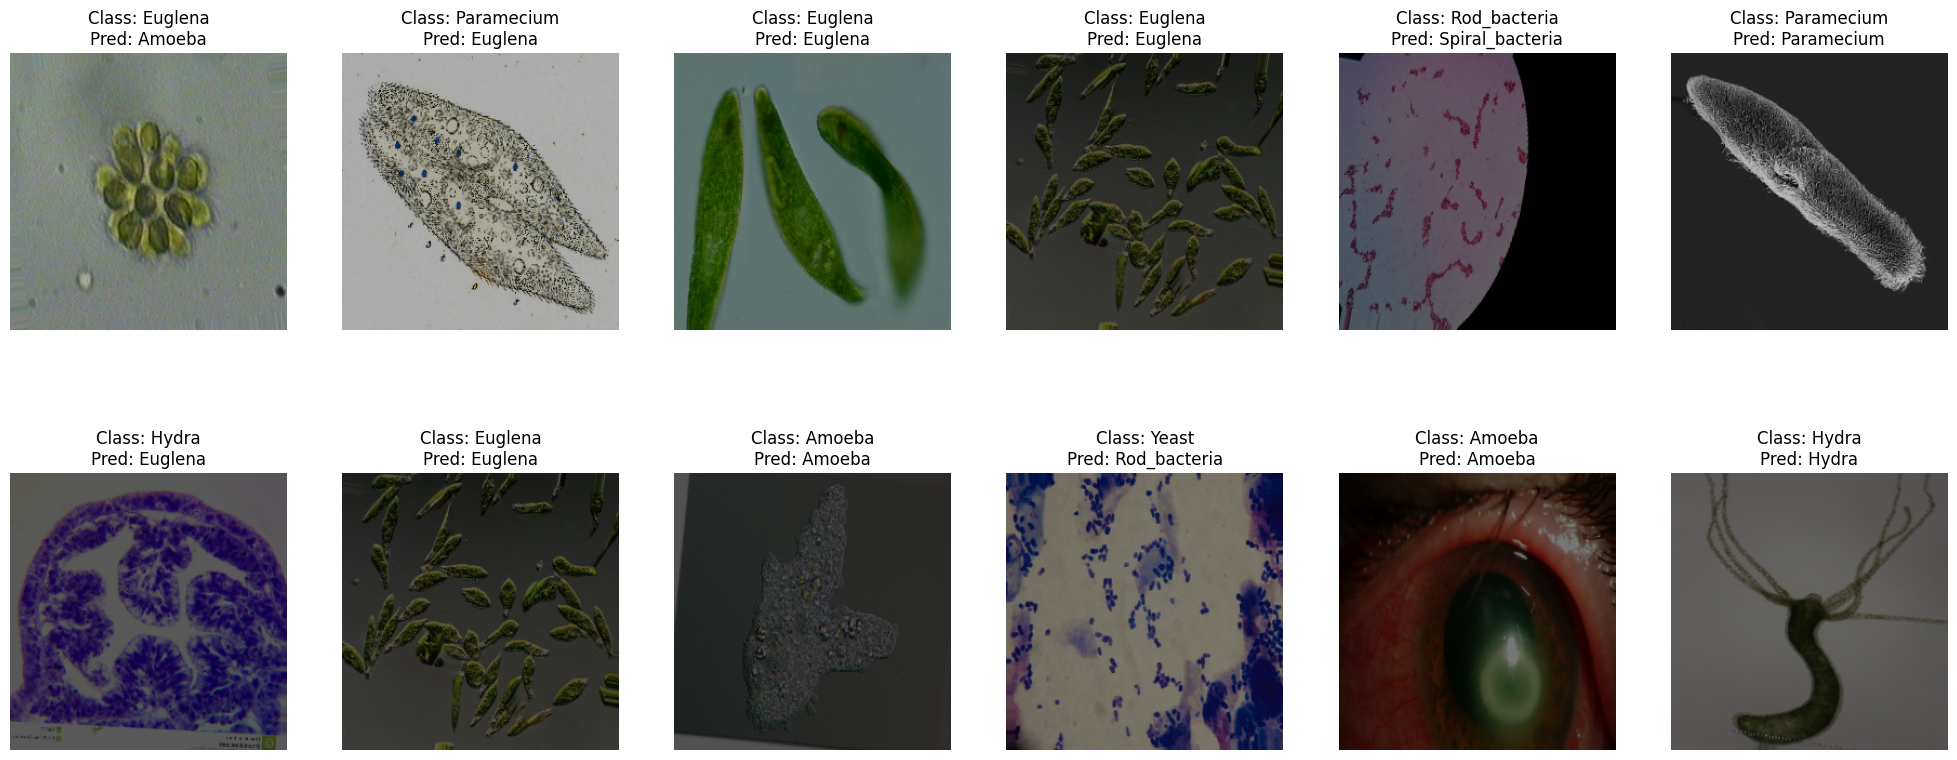

In [13]:
visualize_images(data = val_df, model=model)

### Implementing GradCAM into Model

In [16]:
target_layer = model.layers[0].layers[-1]
print(f"Using target layer: {target_layer.name}")


images_by_class = {}

while len(images_by_class) < n_classes:
    images, labels = next(val_df)
    for img, label in zip(images, labels):
        label_index = int(label)
        # If we haven't seen this class yet, store the image
        if label_index not in images_by_class:
            images_by_class[label_index] = img
        # If we have all 8, stop searching
        if len(images_by_class) == n_classes:
            break


sorted_items = sorted(images_by_class.items())
sample_images = np.array([item[1] for item in sorted_items])
sample_labels = np.array([item[0] for item in sorted_items])


preds = model.predict(sample_images)
pred_indices = np.argmax(preds, axis=1)


targets = [ClassifierOutputTarget(index) for index in pred_indices]

Using target layer: mixed10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [28]:
def generate_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions.
    # --- THIS IS THE CORRECTED PART ---
    base_model = model.get_layer('inception_v3') # Get the base model layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [base_model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron with regard to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by "how important this channel is"
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [29]:
# Get the name of the last convolutional layer in the InceptionV3 base model
last_conv_layer_name = model.layers[0].layers[-1].name

plt.figure(figsize=(24, 8))
for i in range(8):
    img = sample_images[i]
    img_array = np.expand_dims(img, axis=0)
    
    # Generate the heatmap using our new pure TensorFlow function
    heatmap = generate_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_indices[i])
    
    # Resize heatmap to match the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Apply the heatmap to the original image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + np.uint8(255 * img)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Get class names for title
    actual_class = classes_names[int(sample_labels[i])]
    predicted_class = classes_names[pred_indices[i]]

    # Plot the original image on the top row
    plt.subplot(2, 8, i + 1)
    plt.imshow(img)
    plt.title(f"Original\nActual: {actual_class}")
    plt.axis('off')
    
    # Plot the CAM visualization on the bottom row
    plt.subplot(2, 8, i + 8 + 1)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM\nPredicted: {predicted_class}")
    plt.axis('off')

plt.suptitle("Grad-CAM Visualization (Pure TensorFlow)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

AttributeError: The layer sequential has never been called and thus has no defined output.

<Figure size 2400x800 with 0 Axes>

### Implementing GradCAM - with Variant 1 into Model 

### Implementing GradCAM with Variant 2 into Model 